In the past, I've done some models using several libraries in Python without really understanding what I was doing. I want to implement multiple learning models, using less -or **none**- *pre-made* ML resources. I hope this will be reflected in a  deeper understanding on what each learning model does.

This time, I'll be implementing **Linear regression** in Python.

I'll be using `pandas` to import and process data sets, `numpy` to get useful linear algebra functions, and `pyplot` to plot graphics.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import and examine data

In [2]:
# import dataframe
df = pd.read_csv('../input/kc_house_data.csv')

By looking at the original dataset, I see that
`df[2], price` will be `y`, my prediction target.
`df[0], id` is not a predictor variable, so I won't include it in my feature matrix `X`, which is all of the remaining columns.

In [3]:
# This re-orders dataframe in a more convenient way for me to work in further steps.
cols = ['id', 'price', 'floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'sqft_living',
        'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'view',
        'waterfront', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'date']
df = df[cols]

# Get y (price), and X (feature matrix)
y = df.iloc[:,1:2].copy()
X = df.iloc[:,2:].copy()

Now, I'll decide which features need to be normalized. To do that, I'll take a look at every feature, and its min and max values.

In [4]:
# This generates a 2 x n matrix, with min and max values of every feature
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])
X.apply(minMax)

,floors,bedrooms,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,lat,long,date
min,1.0,0,0.0,1,1,290,520,290,0,399,651,0,0,1900,0,98001,47.1559,-122.519,20140502T000000
max,3.5,33,8.0,5,13,13540,1651359,9410,4820,6210,871200,4,1,2015,2015,98199,47.7776,-121.315,20150527T000000


`floors`, `bedrooms`, `bathrooms`, `condition`, `grade`, and `view` **can** be normalized and scaled, and doing isn't bad, so i'll do it.

All `sqft_#` features **should** be normalized and scaled.

`waterfront` acts like a boolean, and takes either 0 or 1. So I won't be normalizing it.

In [5]:
# Array containing the indexes of the columns to normalize
toNormalize = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

To normalize, we implement the mathematical model into a python function

$$
x_{i}:=\dfrac{x_{i}−\mu_{i}}{s_{i}}
$$

In [6]:
# X is the feature matrix, and a the array of the features to be normalized
def normalize(X, arr):
    X_norm = X[:]    # copy feature matrix
    mu = []          # median matrix
    sigma = []       # std matrix
    for i in range(len(arr)):
        mu.append(X_norm.iloc[:,arr[i]].mean())        # append median of (arr[i]th) column
        sigma.append(X_norm.iloc[:,arr[i]].std())      # append std of (arr[i]th)column
        # normalize (arr[i]th) column
        X_norm.iloc[:,arr[i]] = (X_norm.iloc[:,arr[i]] - mu[i]) / sigma[i]
    return mu, sigma, X_norm

# mu list contains median of all normalized columns
# sigma list contains std of all normalized columns
# X_norm is X matrix normalized
[mu, sigma, X_norm] = normalize(X, toNormalize)
X_norm

,floors,bedrooms,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,lat,long,date
0,-0.915406,-0.398728,-1.447430,-0.629172,-0.558823,-0.979812,-0.228316,-0.734691,-0.658666,-0.943333,-0.260709,-0.305752,0,1955,0,98178,47.5112,-122.257,20141013T000000
1,0.936484,-0.398728,0.175603,-0.629172,-0.558823,0.533622,-0.189881,0.460830,0.245136,-0.432676,-0.187863,-0.305752,0,1951,1991,98125,47.7210,-122.319,20141209T000000
2,-0.915406,-1.473925,-1.447430,-0.629172,-1.409554,-1.426221,-0.123296,-1.229805,-0.658666,1.070115,-0.172371,-0.305752,0,1933,0,98028,47.7379,-122.233,20150225T000000
3,-0.915406,0.676469,1.149422,2.444237,-0.558823,-0.130547,-0.244009,-0.891678,1.397483,-0.914153,-0.284515,-0.305752,0,1965,0,98136,47.5208,-122.393,20141209T000000
4,-0.915406,-0.398728,-0.149004,-0.629172,0.291909,-0.435412,-0.169649,-0.130892,-0.658666,-0.272184,-0.192844,-0.305752,0,1987,0,98074,47.6168,-122.045,20150218T000000
5,-0.915406,0.676469,3.097062,-0.629172,2.844104,3.636707,2.096136,2.537897,2.798375,4.046517,3.265491,-0.305752,0,2001,0,98053,47.6561,-122.005,20140512T000000
6,0.936484,-0.398728,0.175603,-0.629172,-0.558823,-0.397303,-0.200093,-0.088626,-0.658666,0.366867,-0.217895,-0.305752,0,1995,0,98003,47.3097,-122.327,20140627T000000
7,-0.915406,-0.398728,-0.798217,-0.629172,-0.558823,-1.110469,-0.130273,-0.879602,-0.658666,-0.491037,-0.111978,-0.305752,0,1963,0,98198,47.4095,-122.315,20150115T000000
8,-0.915406,-0.398728,-1.447430,-0.629172,-0.558823,-0.326531,-0.184376,-0.891678,0.990772,-0.301364,-0.170503,-0.305752,0,1960,0,98146,47.5123,-122.337,20150415T000000
9,0.936484,-0.398728,0.500209,-0.629172,-0.558823,-0.206763,-0.206346,0.122703,-0.658666,0.588638,-0.190390,-0.305752,0,2003,0,98038,47.3684,-122.031,20150312T000000


Now we modify X_norm, adding the intercept term.

In [7]:
X_norm['temp'] = 1
X_norm.insert(0, 'intercept', X_norm['temp'])
X_norm.pop('temp')
X_norm

,intercept,floors,bedrooms,bathrooms,condition,grade,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,lat,long,date
0,1,-0.915406,-0.398728,-1.447430,-0.629172,-0.558823,-0.979812,-0.228316,-0.734691,-0.658666,-0.943333,-0.260709,-0.305752,0,1955,0,98178,47.5112,-122.257,20141013T000000
1,1,0.936484,-0.398728,0.175603,-0.629172,-0.558823,0.533622,-0.189881,0.460830,0.245136,-0.432676,-0.187863,-0.305752,0,1951,1991,98125,47.7210,-122.319,20141209T000000
2,1,-0.915406,-1.473925,-1.447430,-0.629172,-1.409554,-1.426221,-0.123296,-1.229805,-0.658666,1.070115,-0.172371,-0.305752,0,1933,0,98028,47.7379,-122.233,20150225T000000
3,1,-0.915406,0.676469,1.149422,2.444237,-0.558823,-0.130547,-0.244009,-0.891678,1.397483,-0.914153,-0.284515,-0.305752,0,1965,0,98136,47.5208,-122.393,20141209T000000
4,1,-0.915406,-0.398728,-0.149004,-0.629172,0.291909,-0.435412,-0.169649,-0.130892,-0.658666,-0.272184,-0.192844,-0.305752,0,1987,0,98074,47.6168,-122.045,20150218T000000
5,1,-0.915406,0.676469,3.097062,-0.629172,2.844104,3.636707,2.096136,2.537897,2.798375,4.046517,3.265491,-0.305752,0,2001,0,98053,47.6561,-122.005,20140512T000000
6,1,0.936484,-0.398728,0.175603,-0.629172,-0.558823,-0.397303,-0.200093,-0.088626,-0.658666,0.366867,-0.217895,-0.305752,0,1995,0,98003,47.3097,-122.327,20140627T000000
7,1,-0.915406,-0.398728,-0.798217,-0.629172,-0.558823,-1.110469,-0.130273,-0.879602,-0.658666,-0.491037,-0.111978,-0.305752,0,1963,0,98198,47.4095,-122.315,20150115T000000
8,1,-0.915406,-0.398728,-1.447430,-0.629172,-0.558823,-0.326531,-0.184376,-0.891678,0.990772,-0.301364,-0.170503,-0.305752,0,1960,0,98146,47.5123,-122.337,20150415T000000
9,1,0.936484,-0.398728,0.500209,-0.629172,-0.558823,-0.206763,-0.206346,0.122703,-0.658666,0.588638,-0.190390,-0.305752,0,2003,0,98038,47.3684,-122.031,20150312T000000


Now, let's stablish the learning rate `alpha`, `num_iters`, and theta vector.

In [8]:
X_norm.pop('date')
alpha = .000000000001
num_iters = 5000
theta = [0] * len(X_norm.columns)

In [9]:
def computeCost(X, y, theta):
    return (X_norm.dot(theta)).subtract(y.iloc[:,0]).pow(2).sum() / (2 * len(y))

def gradientDescent(X_sample, y_sample, theta_sample, alpha, num_iters):
    m = len(y)
    J_history = []
    for i in range(num_iters):
        error = (X_sample.dot(theta)).subtract(y_sample.iloc[:,0]);
        for j in range(len(theta_sample)):
            if (m == 0):
                print("pendejo")
            else:
                theta_sample[j] = theta_sample[j]-(alpha * error.multiply(X_sample.iloc[:,j]).sum())/m;

        J_history.append(computeCost(X_sample, y_sample, theta_sample));
        if ((i>1) and J_history[i-1] - J_history[i] < .001):
            print ("HAHA")
            return theta, J_history
    return theta, J_history

alpha = .0000000002
theta = [0] * len(X_norm.columns)
[theta, J_history] = gradientDescent(X_norm,y, theta, alpha,500)
# print(J_history)
# print(y_sample)

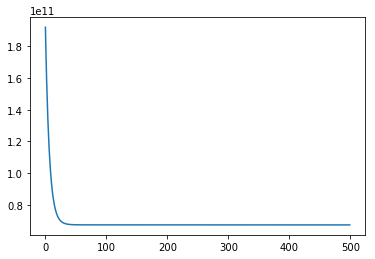

In [10]:
# X_sample = X_norm.iloc[0:20,:]
# y_sample = y.iloc[0:20,:]
# [0] * len(X_sample.columns)

plt.plot(J_history)

In [11]:
ids = [3271300955,9830200380,4385700735,4385700765,1776460190,4040800360,9828700005,3024079063,
       6430500293,293910070,3449900030,7308900490,7852020250,3630200460,3425059141,259800410,
       6928600330,3905040070,2922701085,7974200777,6699300330,1118001360,1330850130,6880200030,
       4458300190,1771100440,8143100500,7424600020,9573120260,7853340330,34001304,1524079156,
       5430300171,1702901500,3751601501,5418650080,2770601800,1523049115,1509700050,8731960050,
       5146000070,5021900090,7550801206,3663500060,11200290,9474700020,616000140,722059020,
       8682220150,2922701175,9267200226,8658300315,1782000180,1221039058,461003835,8864000970,
       4222700130,1972202023,2725069164,4363700200,6431000749,7625702616,1771110720,8731951370,
       2473480560,7893800534,1561900180,3298700941,6713100031,7137900320,3205100080,4345000490,
       9558021010,724069070,3124049171,7839300185,5009600010,1922069099,8137500400,7582700075,
       9250900104,4178300040,3904920390,4305200070,7419500200,4157600120,7853321090,6021502300,
       7844200040,2968801130,1498303905,3383900048,5592900020,7519000585,1102000514,375000165,
       9165100375,8091400200,7985000010,3583300135]

results = pd.DataFrame()
for i in ids:
    ID = df.index[df['id'] == i].tolist()[0]
    temp = pd.DataFrame([[df.iloc[ID,0], df.iloc[ID,1], X_norm.iloc[ID,:].dot(theta)]], columns=['id', 'real', 'predicted'])
    results = results.append(temp, ignore_index=True)

results

,id,real,predicted
0,3271300955,554729.0,540582.404123
1,9830200380,653000.0,540145.484473
2,4385700735,790000.0,540100.215864
3,4385700765,850000.0,543782.908524
4,1776460190,429900.0,539603.435249
5,4040800360,420000.0,539534.894919
6,9828700005,440000.0,540159.801832
7,3024079063,850000.0,539647.109655
8,6430500293,395000.0,540049.786116
9,293910070,653750.0,539684.979558


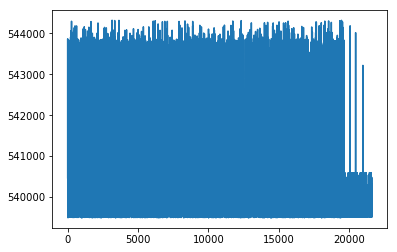

In [12]:
plt.plot(X_norm.dot(theta))